**String cleaning**

In [43]:
text = """abc      sdz\n\n   asdask23 32 32 d3  
zxcxz
zxcxzc

3 23"""

print(re.sub('\s+',' ', text))
print(re.sub(r'[\t\n\r\f\v ]+', ' ', text))

abc sdz asdask23 32 32 d3 zxcxz zxcxzc 3 23
abc sdz asdask23 32 32 d3 zxcxz zxcxzc 3 23


In [19]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

text = "hi i am having a really good day today @elonmusk https://t.co/8A6N7QLg53"
text = "RT @c2412345: MANDATING wearing masks in public is starting www.nos.nl !"
text = "Cramer: Trump's 'onslaught against Amazon' creates major market risk https://t.co/yKaf8LKKy2 @jimcramer $FB $AMZN $NFLX $GOOGL @cnbc"
#remove twitter Return handles (RT @xxx:)
text = re.sub("RT @[\w]*:", "", text)
print(f"Checkmark 1: {text}")

#remove twitter handles (@xxx)
text = re.sub("@[\w]*", "", text)
print(f"Checkmark 2: {text}")

#remove URL links (httpxxx)
url_matcher = "((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
text = re.sub(url_matcher, "", text)
print(f"Checkmark 3: {text}")

text

Checkmark 1: Cramer: Trump's 'onslaught against Amazon' creates major market risk https://t.co/yKaf8LKKy2 @jimcramer $FB $AMZN $NFLX $GOOGL @cnbc
Checkmark 2: Cramer: Trump's 'onslaught against Amazon' creates major market risk https://t.co/yKaf8LKKy2  $FB $AMZN $NFLX $GOOGL 
Checkmark 3: Cramer: Trump's 'onslaught against Amazon' creates major market risk   $FB $AMZN $NFLX $GOOGL 


"Cramer: Trump's 'onslaught against Amazon' creates major market risk   $FB $AMZN $NFLX $GOOGL "

In [1]:
text = "test 123"

bool(re.search(r"Test", text, re.IGNORECASE))

NameError: name 're' is not defined

**Vader sentiment**

In [ ]:
!pip install nltk
import nltk

nltk.downloader.download('vader_lexicon')


In [49]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

text = "Although the global market is doing well, $tsla is experiencing a downturn."
result = analyser.polarity_scores(text)
print(result)

# text = "hi i am not having a really good day today!!!"
# result = analyser.polarity_scores(text)
# print(result)

# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# analyser = SentimentIntensityAnalyzer()

# text = "hi i am not having a really good day today!!!"
# result = analyser.polarity_scores(text)
# print(result)

# text = "Although the global market is experiencing a downturn, food companies are doing well thanks to Covid."
# result = analyser.polarity_scores(text)
# print(result)


{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compound': 0.2732}


In [8]:
d = {'col1': [1, 2,5,5], 'col2': [3, 4,5,5]}
df = pd.DataFrame(data=d)
def test_f(value):
    if value == 5:
        return True
    else:
        return False
df['test'] = df['col2'].apply(test_f)

df[df['test']]

,col1,col2,test
2,5,5,True
3,5,5,True


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [2]:
path = r"E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\NFLX.csv"
df = pd.read_csv(path)

### Filter, clean and sentiment functions

The code below contains functions which are used on the dataframe to:
- Perform data cleaning
- Filter the data
- Calculate the sentiment

The **<u>data filtering</u>** will be done using 2 different methods.
- Method 1: Filters observations with based on the number of tickers which are mentioned in the Tweet. If this number differs from 1 ticker mentioned, the post is filtered. The second rule of this filter method is that the 1 ticker which is mentioned, is that this ticker is the ticker of the company of which the sentiment is being calculated.
- Method 2: This method is more lenient and allows for multiple tickers to be mentioned, as long as the company ticker which is being investigated is also mentioned.

The **<u>sentiment calculations</u>** will also be done using 2 different methods using the [cjhutto vaderSentiment library](https://github.com/cjhutto/vaderSentiment).
- Method 1: Uses the original cjhutto vaderSentiment library. 
- Method 2: Uses the original cjhutto vaderSentiment library, however some word-sentiment pairs are added to finetune the VADER model for financial texts. 

In [44]:
#   ---------------------------   Data cleaning   ---------------------------
def clean_text(text):
    # Remove twitter Return handles (RT @xxx:)
    text = re.sub("RT @[\w]*:", "", text)

    # Remove twitter handles (@xxx)
    text = re.sub("@[\w]*", "", text)

    # Remove URL links (httpxxx)
    url_matcher = "((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
    text = re.sub(url_matcher, "", text)
    
    # Remove any multiple white spaces, tabs or newlines
    text = re.sub('\s+',' ', text)
    
    #remove “”
    text = re.sub("“|”", "", text)
    
    return text

#   ---------------------------   Data filtering   ---------------------------

# Method 1 filters the posts based on only 1 rule, which is that the ticker of the company of ...
# ... which the sentiment is being calculated is present.
def filter_data_1(post, ticker):
    # Filter out posts that do not mention the company ticker.
    if bool(re.search(fr"\${ticker}", post, re.IGNORECASE)):
        return True
    else:
        return False 

# Method 2 filters the posts based on the rule that exactly 1 ticker is mentioned and ...
# ... that this ticker is the ticker of the company of which the sentiment is being calculated   
def filter_data_2(post, ticker):
    # Count the number of tickers in the post
    matches = re.findall(r"\$[a-zA-Z]+", post)
    count = len(matches)
    
    # Filter out posts with more or less than 1 ticker, and check whether this 1 ticker is the company ticker.
    if count == 1 and bool(re.search(fr"\${ticker}", post, re.IGNORECASE)):
        return True
    else:
        return False




In [4]:
# Adding word-sentiment pairs to the cjhutto vaderSentiment library.
new_words = {}

# Adding custom postive words
positive_words = {
    'buy': 2.0,
    'buying': 2.0,
    'bullish': 2.0,
    'long': 1.0,
    'call': 1.0,
    'calls': 1.0,
    'rocket': 3.0,        # Added for 'rocket' emoji 🚀
    'increasing': 2.0,     # Added for 'chart increasing' emoji 📈
    'to the moon': 2.5,
    "undervalued": 2.0
}
# Adding custom negative words
negative_words = {
    'decreasing': -2.0,   # Added for 'chart increasing' emoji 📉
    'sell': -2.0,
    'selling': -2.0,
    'bearish': -2.0,
    'put': -1,
    'puts': -1,
    'short': -1.0,
    'shorting': -1.5,
    "overvalued": -2.0,
    'expensive': -1.5
}

# Adding positive and negative words to new_worddictionary
new_words.update(positive_words)
new_words.update(negative_words)

In [51]:
#   ---------------------------   Sentiment   ---------------------------
# Creating SIA, which uses standard words.
SIA = SentimentIntensityAnalyzer()

def calc_sentiment_1(text, sent_type):
    result = SIA.polarity_scores(text)
    return result[sent_type]

# Creating SIA2 to add custom words.
SIA2 = SentimentIntensityAnalyzer()
SIA2.lexicon.update(new_words)

def calc_sentiment_2(text, sent_type):
    result = SIA2.polarity_scores(text)
    return result[sent_type]

In [84]:
import time
start_time = time.time()

def clean_data(df, ticker):
    # Drop all non English Tweets and any unnnamed columns
    df = df[df['lang'] == 'en']
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # Create some datetime items
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['date'] = df['created_at'].dt.date
    df['hour'] = df['created_at'].dt.hour
#     df['test'] = df['text'].apply(filter_data_1, ticker=ticker)
    
    #   ---------------------------   Data cleaning   ---------------------------
    # Clean text
    df['text'] = df['text'].apply(clean_text)
    print("Done cleaning after --- %s seconds ---" % (time.time() - start_time))
    
    # Drop duplicate tweets based on cleaned text (sometimes Tweets include the same text but different links for example)
    df = df.drop_duplicates(subset=['author_id', 'text'], keep=False)
    
    #   ---------------------------   Data filter   ---------------------------
    # Filter dataframe using both filter 1 and 2 (read above what they mean)
    df['filter_1'] = df['text'].apply(filter_data_1, ticker=ticker)
    df['filter_2'] = df['text'].apply(filter_data_2, ticker=ticker)
    
    print("Done filtering after --- %s seconds ---" % (time.time() - start_time))
    
    #   ---------------------------   Sentiment   ---------------------------
    # Calculate sentiment scores
    df[f'compound_sent_1'] = df['text'].astype(str).apply(calc_sentiment_1, sent_type='compound')
    df[f'compound_sent_2'] = df['text'].astype(str).apply(calc_sentiment_2, sent_type='compound')
    
    print("Done calculating sentiment after --- %s seconds ---" % (time.time() - start_time))
    
    """Converting this to pos, neg or neu sentiment
    - positive sentiment: compound score >= 0.05
    - neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
    - negative sentiment: compound score <= -0.05
    """
    
    # Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_1
    df['s1_pos'] = np.where(df['compound_sent_1'] >= 0.05, 1, 0)
    df['s1_neg'] = np.where(df['compound_sent_1'] <= -0.05, 1, 0)

    # Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_2
    df['s2_pos'] = np.where(df['compound_sent_2'] >= 0.05, 1, 0)
    df['s2_neg'] = np.where(df['compound_sent_2'] <= -0.05, 1, 0)


    
    
    return df

ticker = 'AMZN'

filedir = r'E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged'
filename = ticker + '.csv'
path = os.path.join(filedir, filename)

df = pd.read_csv(path)

return_df = clean_data(df, ticker)

Done cleaning after --- 31.438969373703003 seconds ---
Done filtering after --- 36.62386155128479 seconds ---
Done sent calcing after --- 223.0270972251892 seconds ---


In [90]:
# Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_1
return_df['s1_pos'] = np.where(return_df['compound_sent_1'] >= 0.05, 1, 0)
return_df['s1_neg'] = np.where(return_df['compound_sent_1'] <= -0.05, 1, 0)
return_df['s1_neu'] = np.where((return_df['compound_sent_1'] > -0.05) & (return_df['compound_sent_1'] < 0.05), 1, 0)

# Check if sentiment corresponds to pos, neg or neu sentiment for compound_sent_2
return_df['s2_pos'] = np.where(return_df['compound_sent_2'] >= 0.05, 1, 0)
return_df['s2_neg'] = np.where(return_df['compound_sent_2'] <= -0.05, 1, 0)
return_df['s2_neu'] = np.where((return_df['compound_sent_2'] > -0.05) & (return_df['compound_sent_1'] < 0.05), 1, 0)

<AxesSubplot:>

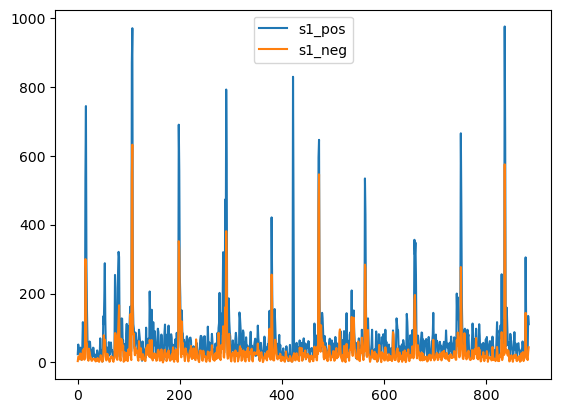

In [76]:
return_df[return_df['filter_1']][['date', 's1_pos', 's1_neg']].groupby('date', as_index=False).sum().plot()
# df.groupby('date').agg(
#         {'price': 'mean', 'size': 'sum', 'buy': 'sum', 'sell': 'sum', 'buy_vol': 'sum', 'sell_vol': 'sum'})
#           .round(2)
#           .rename(columns={'size': 'total_vol'})

,date,f1s1_pos,f1s1_neg,f1s1_total,f1s1_ratio,f1s1_ratio_Δ%
0,2018-04-01,119,68,187,0.636364,NaN
1,2018-04-02,501,401,902,0.555432,0.636364
2,2018-04-03,782,548,1330,0.587970,0.555432
3,2018-04-04,495,230,725,0.682759,0.587970
4,2018-04-05,395,160,555,0.711712,0.682759
...,...,...,...,...,...,...
880,2020-08-28,479,184,663,0.722474,0.670085
881,2020-08-29,326,162,488,0.668033,0.722474
882,2020-08-30,229,63,292,0.784247,0.668033
883,2020-08-31,750,224,974,0.770021,0.784247


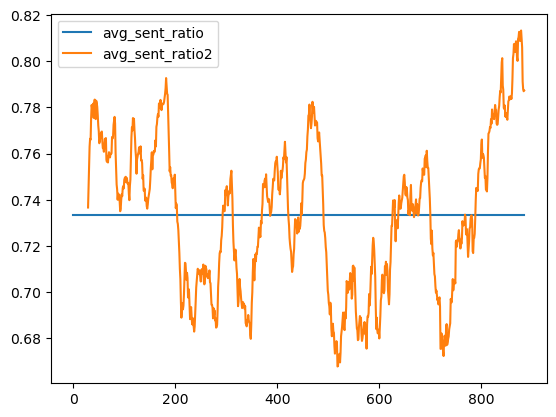

In [103]:
# Create results_df with [filter_1] [sentiment_1]
results_df = return_df[return_df['filter_1']][['date', 's1_pos', 's1_neg']].groupby('date', as_index=False).sum().rename(columns={"s1_pos": "f1s1_pos", "s1_neg": "f1s1_neg"})
results_df['f1s1_total'] = results_df['f1s1_pos'] + results_df['f1s1_neg']
results_df['f1s1_ratio'] = results_df['f1s1_pos'] / results_df['f1s1_total']
# results_df['f1s1_ratio_Δ%'] = results_df['f1s1_ratio'].diff() / results_df['f1s1_total']
results_df['f1s1_ratio_Δ%'] = results_df['f1s1_ratio'].shift()
results_df['test2%'] = results_df['f1s1_ratio'].rolling(60).mean()

# Merge [filter_1] [sentiment_2]
to_merge_df = return_df[return_df['filter_1']][['date', 's2_pos', 's2_neg']].groupby('date', as_index=False).sum().rename(columns={"s2_pos": "f1s2_pos", "s2_neg": "f1s2_neg"})
to_merge_df['f1s2_total'] = to_merge_df['f1s2_pos'] + to_merge_df['f1s2_neg']
to_merge_df['f1s2_ratio'] = to_merge_df['f1s2_pos'] / to_merge_df['f1s2_total']

results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')

# Merge [filter_2] [sentiment_1]
to_merge_df = return_df[return_df['filter_2']][['date', 's1_pos', 's1_neg']].groupby('date', as_index=False).sum().rename(columns={"s1_pos": "f2s1_pos", "s1_neg": "f2s1_neg"})
to_merge_df['f2s1_total'] = to_merge_df['f2s1_pos'] + to_merge_df['f2s1_neg']
to_merge_df['f2s1_ratio'] = to_merge_df['f2s1_pos'] / to_merge_df['f2s1_total']

results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')

# Merge [filter_2] [sentiment_2]
to_merge_df = return_df[return_df['filter_2']][['date', 's2_pos', 's2_neg']].groupby('date', as_index=False).sum().rename(columns={"s2_pos": "f2s2_pos", "s2_neg": "f2s2_neg"})
to_merge_df['f2s2_total'] = to_merge_df['f2s2_pos'] + to_merge_df['f2s2_neg']
to_merge_df['f2s2_ratio'] = to_merge_df['f2s2_pos'] / to_merge_df['f2s2_total']

results_df = results_df.merge(to_merge_df, how='left', left_on='date', right_on='date')
# results_df['test2%'].plot()
results_df['avg_sent_ratio'] = results_df['f2s2_ratio'].mean()
results_df['avg_sent_ratio2'] = results_df['f2s2_ratio'].rolling(30).mean()
results_df['avg_sent_ratio3'] = results_df['f2s2_ratio'].rolling(7).mean()


results_df[['avg_sent_ratio','avg_sent_ratio2']].plot()

results_df.iloc[:,:6]

In [100]:
return_df[return_df['date'] == '2020-03-21']

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,lang,retweets,...,date,hour,filter_1,filter_2,compound_sent_1,compound_sent_2,s1_pos,s1_neg,s2_pos,s2_neg
0,969419426943483904,imamharissuhud,115,774,I am 30 YO,NaN,🚀🔥Actors on 🚀🔥 #bitcoin #ZigguratICO #blockch...,2018-04-05 23:59:28+00:00,en,86,...,2018-04-05,23,False,False,-0.3400,0.7650,0,1,1,0
1,969419426943483904,imamharissuhud,115,774,I am 30 YO,NaN,🚀🔥Simplicity for claim market 🚀🔥 #bitcoin #Zi...,2018-04-05 23:59:10+00:00,en,86,...,2018-04-05,23,False,False,-0.3400,0.7650,0,1,1,0
2,969419426943483904,imamharissuhud,115,774,I am 30 YO,NaN,🚀🔥Free market tokens on Ecex Exchange 🚀🔥 🚀🔥 #...,2018-04-05 23:58:53+00:00,en,89,...,2018-04-05,23,False,False,-0.5859,0.8481,0,1,1,0
3,969419426943483904,imamharissuhud,115,774,I am 30 YO,NaN,🚀🔥Mobile payment for Ziggurats 🚀🔥 🚀🔥 #bitcoin...,2018-04-05 23:58:28+00:00,en,92,...,2018-04-05,23,False,False,-0.5859,0.8481,0,1,1,0
4,969419426943483904,imamharissuhud,115,774,I am 30 YO,NaN,🚀🔥Ziggurat ICO address 🚀🔥 🚀🔥 #bitcoin #crypto...,2018-04-05 23:58:08+00:00,en,96,...,2018-04-05,23,False,False,-0.5859,0.8481,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869108,1012359390,IrishAggie10,304,3658,"Have a real job, but prefer to day trade. Some...",NaN,here’s your $AMZN catalyst for tomorrow...,2020-08-28 00:01:40+00:00,en,0,...,2020-08-28,0,True,True,0.0000,0.0000,0,0,0,0
869109,711603302,Philips_247,1562,37010,"#OutforEggs #DD 🌊\n\n⚡float like a butterfly, ...","Tampa, FL",$AMZN Amazon launches first Amazon Fresh groc...,2020-08-28 00:01:36+00:00,en,1,...,2020-08-28,0,True,True,0.5719,0.5719,1,0,1,0
869110,263793158,FinTwitAMZN,724,3554,A curated community of high quality $AMZN disc...,Wall St,via psk2329: $AMZN Amazon launches first Amazo...,2020-08-28 00:01:35+00:00,en,0,...,2020-08-28,0,True,False,0.5719,0.5719,1,0,1,0
869111,1285352866715242496,MichaelBW80,1099,113708,I retweet only hot stocks tweets\nThe best fro...,NaN,Scary dip today. Did you hold through or buy ...,2020-08-28 00:01:32+00:00,en,3,...,2020-08-28,0,True,False,-0.5514,-0.1431,0,1,0,1


ValueError: x and y must have same first dimension, but have shapes (885,) and (1,)

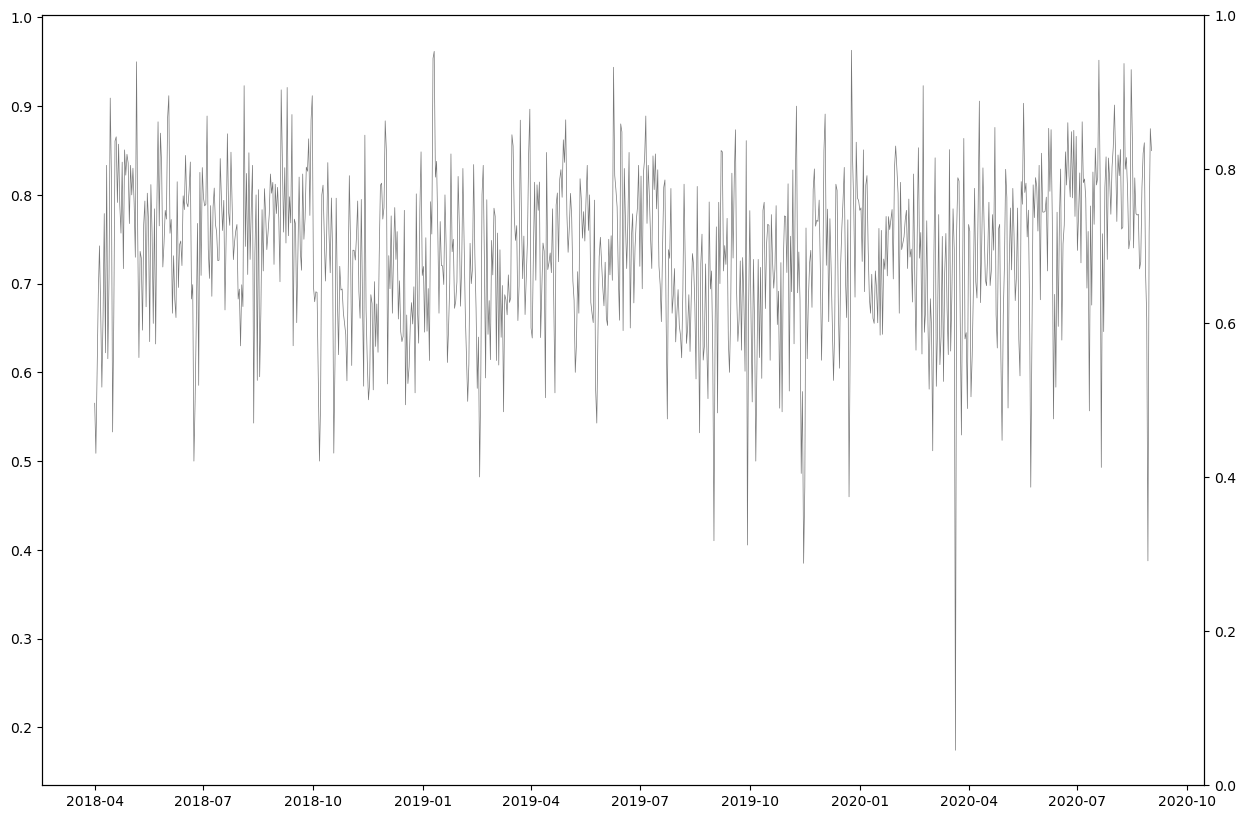

In [89]:
def plot_graph(df, ticker, x='date', y1='performance_1', y2='[taq]price'):
    
    fig, ax1 = plt.subplots(figsize=(15, 10))
    ax2 = ax1.twinx()

    colour_1 = "#777777"
    colour_2 = "#ef0000"
    colour_3 = "#008800"
    colour_4 = "#aa22ff"
    
    ax1.plot(df[x], df[y1], label=y1, color=colour_1, lw=0.5) 
#     ax2.plot(df[x], df['f2s2_pos'].rolling(20).mean(), label=y2, color=colour_3, lw=1.5)
    ax2.plot(df[x], df['f2s2_total'].rolling(20).mean(), label='f2s2_total', color=colour_4, lw=1.5)

    # This line is a rolling average, useful for getting a better view of the data
    ax1.plot(df[x], df[y1].rolling(20).mean(), label=f"{y1}_rolling mean", color=colour_2, lw=2.5)
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel(y1, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()

    ax2.set_ylabel("f2s2_total", color=colour_4, fontsize=14)
    ax2.tick_params(axis="y")
    
    ax1.legend(loc = "upper left")
    ax2.legend(loc = "upper right")
    fig.suptitle(f"[{ticker}] {y1} vs {y2}", fontsize=20)
    fig.autofmt_xdate()
    plt.show()

plot_graph(results_df, 'NFLX', y1='f2s2_ratio', y2='f2s2_pos')

C:\Users\Christiaan\AppData\Local\Temp\ipykernel_8664\1017810257.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['date'], dtype='object')
  results_df[['date', 'f1s2_ratio', 'f2s2_ratio']].rolling(20).mean().plot()


<AxesSubplot:>

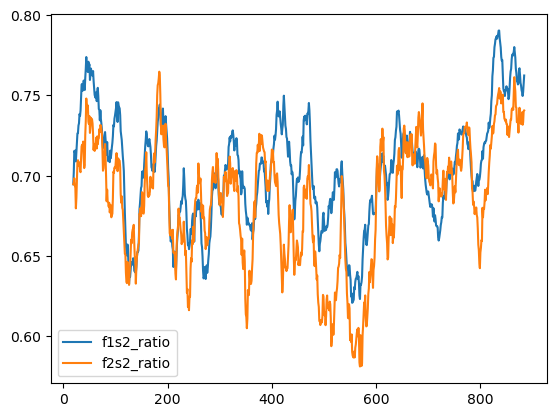

In [145]:
# results_df.loc[:, results_df.columns != 'date']
results_df[['f1s2_ratio', 'f2s2_ratio']].rolling(20).mean().plot()

In [133]:
graph_df

,date,f1s1_pos,f1s1_neg,f1s1_total,f1s2_pos,f1s2_neg,f1s2_total,f2s1_pos,f2s1_neg,f2s1_total,f2s2_pos,f2s2_neg,f2s2_total
95,2018-07-05,143.879735,46.267400,190.147135,154.625964,50.954899,205.580863,53.166748,17.948493,71.115241,58.246625,21.072669,79.319294
96,2018-07-06,144.983891,46.703473,191.687363,155.817758,51.464355,207.282113,53.840392,18.173851,72.014242,58.936711,21.336939,80.273651
97,2018-07-07,146.218102,47.220542,193.438644,157.153392,52.062669,209.216061,54.599657,18.450532,73.050189,59.724497,21.658145,81.382642
98,2018-07-08,147.567385,47.812597,195.379982,158.616165,52.743308,211.359473,55.434993,18.775819,74.210813,60.599371,22.033113,82.632484
99,2018-07-09,149.017736,48.473909,197.491645,160.190459,53.500019,213.690478,56.338172,19.147375,75.485547,61.552112,22.459088,84.011201
...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,2020-08-28,310.625304,107.233712,417.859016,341.338741,113.996093,455.334834,107.017020,46.253070,153.270090,121.130311,50.368788,171.499099
881,2020-08-29,311.500436,108.181684,419.682120,342.281022,114.928236,457.209258,108.221601,46.889550,155.111151,122.393830,51.040073,173.433902
882,2020-08-30,311.761078,108.888079,420.649157,342.551854,115.604435,458.156289,109.099654,47.367968,156.467622,123.286677,51.545218,174.831895
883,2020-08-31,311.409856,109.343336,420.753192,342.153918,116.015008,458.168926,109.640808,47.682134,157.322942,123.798184,51.877304,175.675488


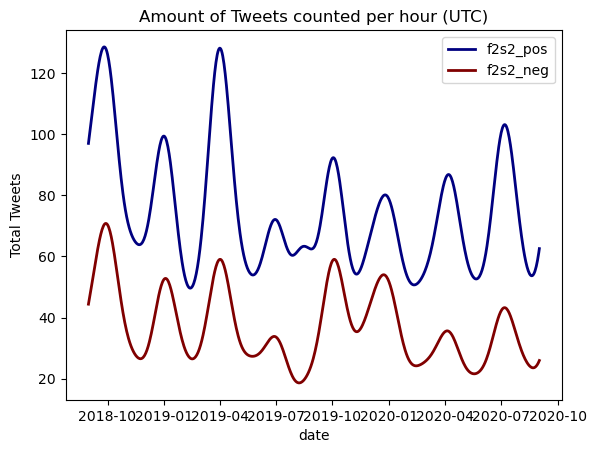

In [136]:
graph_df = results_df
graph_df.loc[:, graph_df.columns != 'date'] = results_df.loc[:, results_df.columns != 'date'].rolling(20).mean()
graph_df.dropna(inplace=True)
# Plot results
ax = graph_df.plot(x="date", y=["f2s2_pos", "f2s2_neg"], lw=2, colormap='jet', markersize=10, title='Amount of Tweets counted per hour (UTC)')
ax.set(xlabel="date", ylabel="Total Tweets")
plt.show()

In [19]:
return_df['sentiment_1'] = return_df['compound_sent'].astype(str).apply(calc_sentiment, sent_type='compound', SIA=SIA)

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,lang,retweets,replies,likes,quote_count,date,hour,test,text2,compound_sent,compound_sent2
26,980534898871209986,thebeezbee,1864,1220,BeeZ with family. BeeZ staying healthy. BeeZ w...,NaN,$NFLX. Fails quiet pullback to the 50DMA consi...,2018-04-05 22:38:33+00:00,en,0,0,0,0,2018-04-05,22,True,$NFLX. Fails quiet pullback to the 50DMA consi...,0.1280,-0.3612
39,953341415710343168,Tosoption,5,97,"Lawyer, Analyst","Vancouver, British Columbia",RT @TOS_OPTION: #TradeUpdate We closed our las...,2018-04-05 21:47:12+00:00,en,1,0,0,0,2018-04-05,21,True,#TradeUpdate We closed our last $NFLX open po...,0.7906,0.7906
41,328741551,bluser12,2175,81170,"markets & macro, politics, health care.","Toronto, Canada",Took off risk cause I see a potential pullback...,2018-04-05 21:41:01+00:00,en,0,2,0,0,2018-04-05,21,True,Took off risk cause I see a potential pullback...,-0.1406,-0.1406
51,40319066,mrmikeflynn,564,36629,Hold the door. Believe in yourself. Take care ...,"Miami, FL",@CNBCFastMoney I’m with @GuyAdami trade 📈 the ...,2018-04-05 21:09:26+00:00,en,0,0,0,0,2018-04-05,21,True,I’m with trade 📈 the $NFLX ! It’s not affect...,0.1867,0.5770
59,885909416205316096,ericdavis221,1472,193036,"Stock posts on this page are NOT Trade Advice,...",NaN,"Apr 05 Thursday, $NFLX closed $293.97",2018-04-05 20:18:40+00:00,en,0,1,0,0,2018-04-05,20,True,"Apr 05 Thursday, $NFLX closed $293.97",0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524676,957789917370896384,jbdridgebacks,1452,95511,Family. Pets. Good Food. Farmlife. Assassin BO...,The Continental,$nflx inside day,2020-08-28 02:06:02+00:00,en,0,0,0,0,2020-08-28,2,True,$nflx inside day,0.0000,0.0000
524683,2270575741,EddieLJP,16,410,World News,NaN,@dhaval_kotecha *Glances at $NFLX ER,2020-08-28 01:58:37+00:00,en,0,0,0,0,2020-08-28,1,True,*Glances at $NFLX ER,0.0000,0.0000
524691,4584354895,MITickWatcher,5435,95126,"Update for stock earnings, dividend, money flo...","California, USA",#Options Flow Grid Update $NFLX #OptionsTradin...,2020-08-28 01:29:03+00:00,en,0,0,0,0,2020-08-28,1,True,#Options Flow Grid Update $NFLX #OptionsTradin...,0.6124,0.6124
524698,7841402,thomaspan,508,60328,NaN,Silicon Valey,RT @TrueBubbleHead: $NFLX inside day! https://...,2020-08-28 01:22:57+00:00,en,1,0,0,0,2020-08-28,1,True,$NFLX inside day!,0.0000,0.0000


In [20]:
# return_df.drop_duplicates(subset=['author_id', 'text2', 'date'], keep=False).shape

# find the duplicates and drop them, keeping only unique rows
clean_df = return_df.drop_duplicates(subset=['author_id', 'text2', 'date'], keep=False)

# find the rows that were dropped
dropped_df = return_df[~return_df.isin(clean_df)].dropna()
dropped_df[dropped_df['username'] == 'MITickWatcher']

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,lang,retweets,replies,likes,quote_count,date,hour,test,text2,compound_sent,compound_sent2


In [18]:
# pd.set_option('display.max_colwidth', None)

for index, row in return_df[['text2', 'compound_sent', 'compound_sent2']].iloc[1000:1400].iterrows():
#     if row['compound_sent'] != row['compound_sent2']:
    print(row['text2'])
    print(f"Sentiment {row['compound_sent']} --> {row['compound_sent2']}")
    print()


 Netflix offering more than $300 million for billboard company: sources    $NFLX
Sentiment 0.0 --> 0.0

 Netflix offering more than $300 million for billboard company: sources    $NFLX
Sentiment 0.0 --> 0.0

Netflix seeks eyeballs on both high &amp; low tech screens. $NFLX 
Sentiment -0.2732 --> -0.2732

 Netflix $NFLX offering $300M for billboard co. Regency Outdoor Advertising - Reuters 


Sentiment 0.0 --> 0.0

Netflix $NFLX offering $300M for billboard co. Regency Outdoor Advertising - Reuters 


Sentiment 0.0 --> 0.0

Netflix offering more than $300 million for billboard company: sources    $NFLX
Sentiment 0.0 --> 0.0

Netflix, Inc. $NFLX Quarterly Estimates Raised at Needham Citing Higher Int'l Subscribers 
Sentiment 0.0 --> 0.0

Raymond James &amp; Associates Buys 490 Shares of Netflix $NFLX  
Sentiment 0.296 --> 0.296

With price to earnings north of 275 and price to sales at 12, Netflix is madly overvalued. The growth potential is not real.  #stocks $NFLX 
Sentiment -0.0258 --

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
SIA = SentimentIntensityAnalyzer()

text = "I am very bearish target $290.55"
# text = "$NFLX wants $300 . Give it some momentum or news and we 🚀🚀"
# text = "Netflix $NFLX Upgraded to Buy by Zacks Investment Research"
# text = "$tsla 🚀🚀🚀"
text = "📈📉"
text = "$NFLX is my hottest playfor April 📈"
text = "Netflix will exist for a long time as a company. It's valuation however is madness. It's too expensive and it's not a viable investment in the long term. $NFLX  #NetflixEurope #StockMarket #stocks #investing"
result = SIA.polarity_scores(text)
print(result)

new_words = {}

# Adding custom postive words
positive_words = {
    'buy': 2.0,
    'buying': 2.0,
    'bullish': 2.0,
    'long': 1.0,
    'call': 1.0,
    'calls': 1.0,
    'rocket': 3.0,        # Added for 'rocket' emoji 🚀
    'increasing': 2.0,     # Added for 'chart increasing' emoji 📈
    'to the moon': 2.5,
    "undervalued": 2.0
}
# Adding custom negative words
negative_words = {
    'decreasing': -2.0,   # Added for 'chart increasing' emoji 📉
    'sell': -2.0,
    'selling': -2.0,
    'bearish': -2.0,
    'put': -1,
    'puts': -1,
    'short': -1.0,
    'shorting': -1.5,
    "overvalued": -2.0,
    'expensive': -1.5
}


# Adding positive and negative words to new_worddictionary
new_words.update(positive_words)
new_words.update(negative_words)

SIA = SentimentIntensityAnalyzer()
SIA.lexicon.update(new_words)


result = SIA.polarity_scores(text)
print(result)

{'neg': 0.083, 'neu': 0.917, 'pos': 0.0, 'compound': -0.4404}
{'neg': 0.141, 'neu': 0.755, 'pos': 0.104, 'compound': -0.34}


In [76]:
print(str("🚀"))

🚀


In [66]:



from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

new_words = {
    'foo': 2.0,
    'bar': -3.4,
}




text = "hi i am not having a really good day today!!!"
result = analyser.polarity_scores(text)
print(result)

text = "Netflix $NFLX Lifted to “Buy” at Vetr #markets"
result = analyser.polarity_scores(text)
print(result)


{'neg': 0.0, 'neu': 0.689, 'pos': 0.311, 'compound': 0.6211}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'compound': -0.5421}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [52]:
df.head(100)

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,lang,retweets,replies,likes,quote_count,date,hour,test
0,235893847,iamtito_,266,40064,Tech enthusiast | A new era already began.,"New York, USA",$NFLX - Statement of Changes in Beneficial Own...,2018-04-05 23:46:02+00:00,en,0,0,0,0,2018-04-05,23,True
1,36458488,resx18,2694,54065,"If someone gives you 10,000 to 1 on anything, ...",#RedSoxNation,$NFLX - Statement of Changes in Beneficial Own...,2018-04-05 23:46:01+00:00,en,0,0,0,0,2018-04-05,23,True
2,3437044841,OACtrading,936,23770,FREE Live Trading Room Focused on Option Tradi...,"Miami, FL",If you are not making money in this market &am...,2018-04-05 23:45:08+00:00,en,0,0,0,0,2018-04-05,23,False
3,4841202432,TopTickrs,2901,152572,Stock Market Chat | Free to Join at https://t....,United States,LEVERAGE VOLATILITY! SHARE IDEAS IN OUR RESEAR...,2018-04-05 23:32:32+00:00,en,0,0,0,0,2018-04-05,23,False
4,364589590,ExactOptionPick,1275,229423,FREE daily option pick emailed to you within 9...,"Miami, FL",ACTIVE TRADERS Try one of these FREE trading g...,2018-04-05 23:30:12+00:00,en,0,0,0,0,2018-04-05,23,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4841202432,TopTickrs,2901,152572,Stock Market Chat | Free to Join at https://t....,United States,LEVERAGE VOLATILITY! CHAT WITH TRADERS ON OUR ...,2018-04-05 18:48:02+00:00,en,0,0,0,0,2018-04-05,18,False
96,25762392,aaaamhim,19432,141737,"I'm Him. Liars never figure, figures don't lie...",Boston,$FLCR .0052?! OVERSOLD!! INSIDERS OWN 40% FOR ...,2018-04-05 18:46:00+00:00,en,0,0,0,0,2018-04-05,18,False
97,3437044841,OACtrading,936,23770,FREE Live Trading Room Focused on Option Tradi...,"Miami, FL","REAL TIME TRADE ALERTS via PRIVATE $TWTR FEED,...",2018-04-05 18:45:08+00:00,en,0,0,0,0,2018-04-05,18,False
98,14051297,docking,2946,30973,Knowledge gives the power to decide. You must ...,USA,$NFLX watching for a break over 295,2018-04-05 18:44:18+00:00,en,0,0,0,0,2018-04-05,18,True


In [51]:
# print(df.dtypes)
for item in df['text'].head(100):
    print(item)
    print()

$NFLX - Statement of Changes in Beneficial Ownership (4) https://t.co/BDv8MBy7K5

$NFLX - Statement of Changes in Beneficial Ownership (4) https://t.co/ENo8Yu4ZkH

If you are not making money in this market &amp; want consistency, try our team https://t.co/hyplyd7Xuk   $SQ $NFLX $AMZN $AMD $TSLA $AAPL $GS

LEVERAGE VOLATILITY! SHARE IDEAS IN OUR RESEARCH BASED CHAT ROOM AT https://t.co/35LuLR0k4f $NFLX $X $GROW

ACTIVE TRADERS Try one of these FREE trading guides:

https://t.co/VKE9Xc6Lg0

$NFLX $TSLA $AAPL $TWTR $GS $FB $AMZN $GOOGL $NVDA

Head-To-Head Survey: Cinedigm $CIDM and Netflix $NFLX https://t.co/ahfbMeW20O

FIND YOUR EDGE! EXPLORE STRATEGIES IN OUR GOAL ORIENTED CHAT ROOM AT https://t.co/35LuLR0k4f $NFLX $SHOP $GROW

Cramer: Trump's 'onslaught against Amazon' creates major market risk https://t.co/yKaf8LKKy2 @jimcramer $FB $AMZN $NFLX $GOOGL @cnbc

$NFLX daily chart looks good. Best part is that it’s not affected by Tariffs. $SPY #Markets https://t.co/CF6TCpt0kp

JOIN NOW! C

<AxesSubplot:>

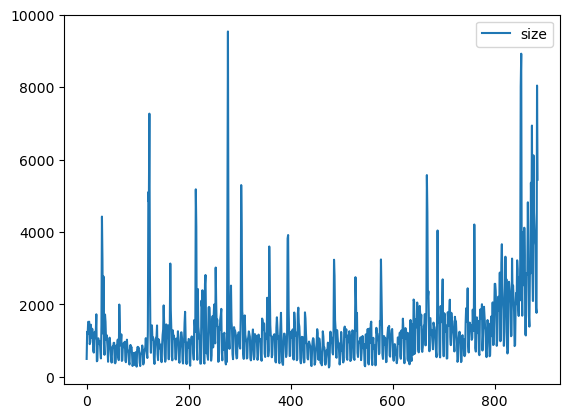

In [31]:
df.groupby('date', as_index=False).size().plot()

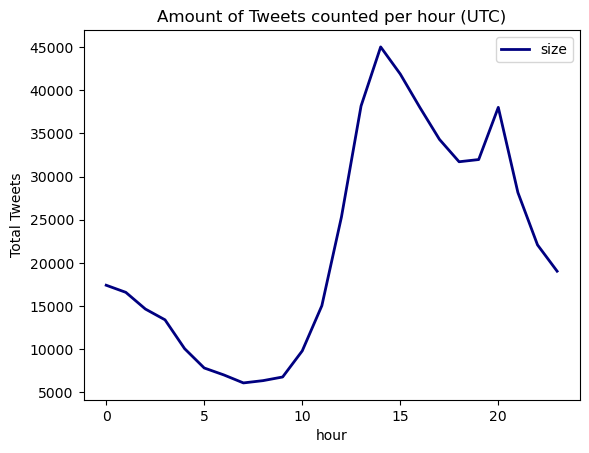

In [28]:
path = r"E:\Users\Christiaan\Large_Files\Thesis\Twitter\merged\NFLX.csv"
df = pd.read_csv(path)

day_activity = df.groupby('hour', as_index=False).size()

# Plot results
ax = day_activity.plot(x="hour", y=["size"], lw=2, colormap='jet', markersize=10, title='Amount of Tweets counted per hour (UTC)')
ax.set(xlabel="hour", ylabel="Total Tweets")
plt.show()

## Graphs

Checking when Twitter activity is highest, it seems that Twitter activity is highest at the 14:00 mark, and lowest at 07:00.

Apple (AAPL) shows the following results
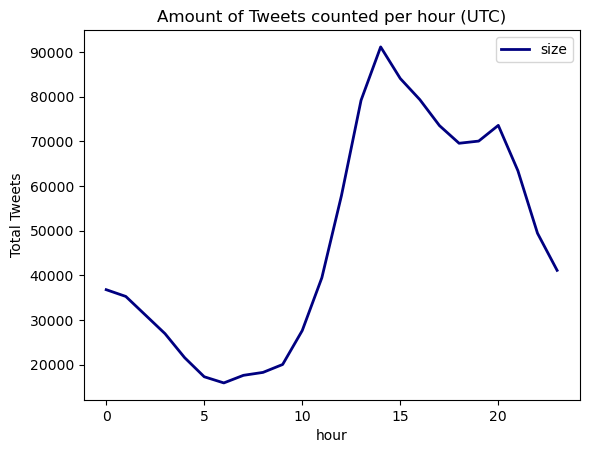

Netflix (NFLX) shows similar results
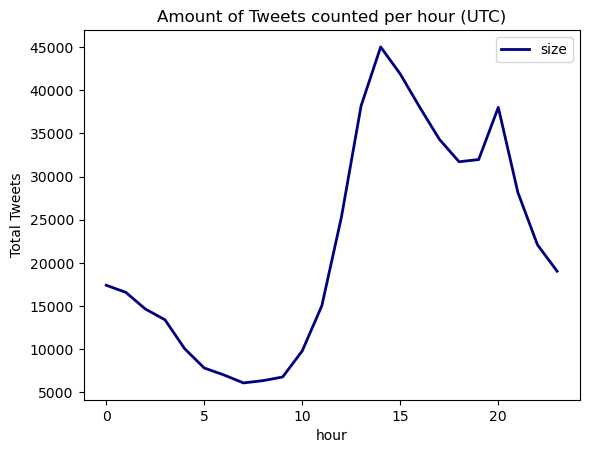